In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.classes = os.listdir(self.root_dir)
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                self.paths.append(os.path.join(class_dir, filename))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image_path = self.paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        return image, label

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and their respective class folders.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_paths = []
        self.labels = []
        
        class_folders = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        
        self.class_to_int = {c: idx for idx, c in enumerate(class_folders)}
        
        for class_folder in class_folders:
            folder_path = os.path.join(root_dir, class_folder)
            for file in os.listdir(folder_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(folder_path, file))
                    self.labels.append(self.class_to_int[class_folder])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB") 
        
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

dataset = CustomImageDataset(root_dir='C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/Train-adj-train-test/train', transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = CustomImageDataset(root_dir='C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/Train-adj-train-test/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

image, label = dataset[0]
print(image.shape, label)

torch.Size([3, 64, 64]) 0


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch.nn.functional as F

In [4]:
# from torch.utils.data import DataLoader
# train_transforms = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor()  
# ])

# dataset = CustomDataset(root_dir='C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/Train-adj/', transform = train_transforms)
# train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
# test_dataset = datasets.ImageFolder(os.path.dirname('C:/Users/denis/Desktop/HNS/projekt1/Dataset_Znacky/test-no-labels/'), transform = train_transforms)


# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN_x(nn.Module):
    def __init__(self, num_classes=12):
        super(SimpleCNN_x, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2)
        self.conv2_alt = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout2d(p=0.2)

        self.fc1 = nn.Linear(65536, 524)
        self.fc2 = nn.Linear(524, num_classes)


    def forward(self, x):
        x1 = F.leaky_relu(self.conv1(x))
        x1 = self.pool(x1)
        
        #branch 1
        x2 = F.leaky_relu(self.conv2(x1))
        x2 = self.pool(x2)
        
        #branch 2
        x2_alt = F.leaky_relu(self.conv2_alt(x1))
        x2_alt = self.pool(x2_alt)
        
        x_combined = torch.cat((x2, x2_alt), 1) 
        
        x_combined = x_combined.view(x_combined.size(0), -1)
        x_combined = self.dropout(x_combined)
        
        x6 = F.leaky_relu(self.fc1(x_combined))
        x6 = self.dropout(x6)
        out = self.fc2(x6)
        
        return out


c:\Users\denis\anaconda3\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/40], Step [0/378], Loss: 2.4846
Epoch [1/40], Step [100/378], Loss: 2.2287
Epoch [1/40], Step [200/378], Loss: 2.3111
Epoch [1/40], Step [300/378], Loss: 2.2055
Epoch [1/40], Average Training Loss: 2.1614
Epoch [1/40], Average Validation Loss: 1.7080
Epoch [2/40], Step [0/378], Loss: 1.8528
Epoch [2/40], Step [100/378], Loss: 1.6492
Epoch [2/40], Step [200/378], Loss: 0.9538
Epoch [2/40], Step [300/378], Loss: 0.7712
Epoch [2/40], Average Training Loss: 1.1806
Epoch [2/40], Average Validation Loss: 0.8503
Epoch [3/40], Step [0/378], Loss: 0.5967
Epoch [3/40], Step [100/378], Loss: 1.0162
Epoch [3/40], Step [200/378], Loss: 0.7403
Epoch [3/40], Step [300/378], Loss: 0.3887
Epoch [3/40], Average Training Loss: 0.6134
Epoch [3/40], Average Validation Loss: 0.4285
Epoch [4/40], Step [0/378], Loss: 0.4315
Epoch [4/40], Step [100/378], Loss: 0.5000
Epoch [4/40], Step [200/378], Loss: 0.3443
Epoch [4/40], Step [300/378], Loss: 0.2649
Epoch [4/40], Average Training Loss: 0.4048
Epoch 

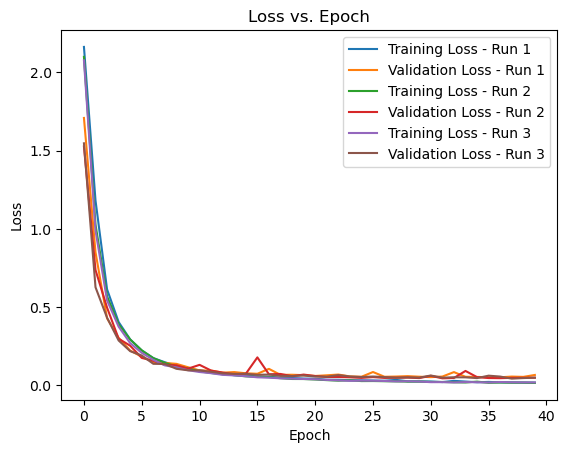

Average Test Accuracy over 3 runs: 98.56%


In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()  
num_epochs = 40
accumulated_test_accuracies = []
num_classes = 12  

for run in range(3): 
    model = SimpleCNN_x().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.8)

    train_loss_values = []
    val_loss_values = []

    for epoch in range(num_epochs):
  
        model.train()
        epoch_train_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            epoch_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:  
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

            torch.cuda.empty_cache()
        avg_train_loss = epoch_train_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Training Loss: {avg_train_loss:.4f}')

       
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(test_loader):  
                data, targets = data.to(device), targets.to(device)

                outputs = model(data)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item()
        avg_val_loss = epoch_val_loss / len(test_loader)
        val_loss_values.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Validation Loss: {avg_val_loss:.4f}')

 
    plt.plot(train_loss_values, label=f"Training Loss - Run {run+1}")
    plt.plot(val_loss_values, label=f"Validation Loss - Run {run+1}")

    print("Training complete.")
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)

       
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total
    accumulated_test_accuracies.append(test_accuracy)

    print(f"Run {run+1} Test Accuracy: {test_accuracy:.2f}%")


average_accuracy = sum(accumulated_test_accuracies) / 3

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.show()
print(f"Average Test Accuracy over 3 runs: {average_accuracy:.2f}%")


In [9]:
model.eval()

test_loss = 0.0
correct = 0
total = 0


with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)


        outputs = model(data)
        loss = criterion(outputs, targets)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()


avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.77%
